In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = "results/train"
train_class = os.listdir(train_dir)
train_class

['Apple',
 'Banana',
 'Cherry',
 'Dragon Fruit',
 'Mango',
 'Orange',
 'Papaya',
 'Pineapple']

In [3]:
val_dir = "results/val"
val_class = os.listdir(val_dir)
val_class

['Apple',
 'Banana',
 'Cherry',
 'Dragon Fruit',
 'Mango',
 'Orange',
 'Papaya',
 'Pineapple']

In [4]:
test_dir = "results/test"
test_class = os.listdir(test_dir)
test_class

['Apple',
 'Banana',
 'Cherry',
 'Dragon Fruit',
 'Mango',
 'Orange',
 'Papaya',
 'Pineapple']

In [5]:
x = [] 
y = []

for folder in os.listdir(train_dir):
    image_list = os.listdir(train_dir + "/" + folder)
    for image_name in image_list:
        img=image.load_img(train_dir+"/"+folder+"/"+image_name,target_size=(224,224))
        img=image.img_to_array(img)
        
        # Transfer Learning: Preprocess of MobileNetV2 model to our images before passing it to MobileNetV2
        img=preprocess_input(img)
        
        x.append(img) # appending image array
        y.append(train_class.index(folder)) # appending class index to the array
        
print("Preparing Training Dataset Completed.")

Preparing Training Dataset Completed.


In [6]:
val_images=[]
val_images_Original=[]
val_image_label=[]

for folder in os.listdir(val_dir):
    image_list=os.listdir(val_dir+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(val_dir+"/"+folder+"/"+img_name,target_size=(224,224))
        
        # Converting to arrarys
        img=image.img_to_array(img)
        
        # Saving original images, will be used just for display at the end
        val_images_Original.append(img.copy())
        img=preprocess_input(img) 
        
        # Appending arrays
        val_images.append(img)
        val_image_label.append(val_class.index(folder))
        
print("Preparing Validation Dataset Completed.")

Preparing Validation Dataset Completed.


In [7]:
x = np.array(x)
x[0].shape

(224, 224, 3)

In [8]:
x.shape

(698, 224, 224, 3)

In [9]:
test_images = []
test_images_Original= []
test_images_label = []
for folder in os.listdir(test_dir):
    image_list = os.listdir(test_dir+"/"+folder)
    for img_name in image_list:
        img = image.load_img(test_dir+"/"+folder+"/"+img_name,target_size = (224,224))
        img = image.img_to_array(img)
        test_images_Original.append(img.copy())
        img = preprocess_input(img)
        
        test_images.append(img)
        test_images_label.append(test_class.index(folder))

In [10]:
x=np.array(x) # Converting to np arrary to pass to the model
print(x.shape)

y=to_categorical(y) # onehot encoding of the labels
print(y.shape)

# Validation Dataset
print("Validation Dataset")

val_images=np.array(val_images) 
print(val_images.shape)

val_image_label=to_categorical(val_image_label) # onehot encoding of the labels)
print(val_image_label.shape)

print("Test Dataset")

test_images=np.array(test_images) 
print(test_images.shape)

test_images_label=to_categorical(test_images_label) # onehot encoding of the labels)
print(test_images_label.shape)

(698, 224, 224, 3)
(698, 8)
Validation Dataset
(83, 224, 224, 3)
(83, 8)
Test Dataset
(95, 224, 224, 3)
(95, 8)


In [11]:
X_train,X_test, y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state =5)
print("The data split is completed")

The data split is completed


*Sample Image*

In [14]:
rand_image = random.sample(os.listdir("results/train/Orange"),8)
rand_image_1 = random.sample(os.listdir("results/train/Apple"),8)

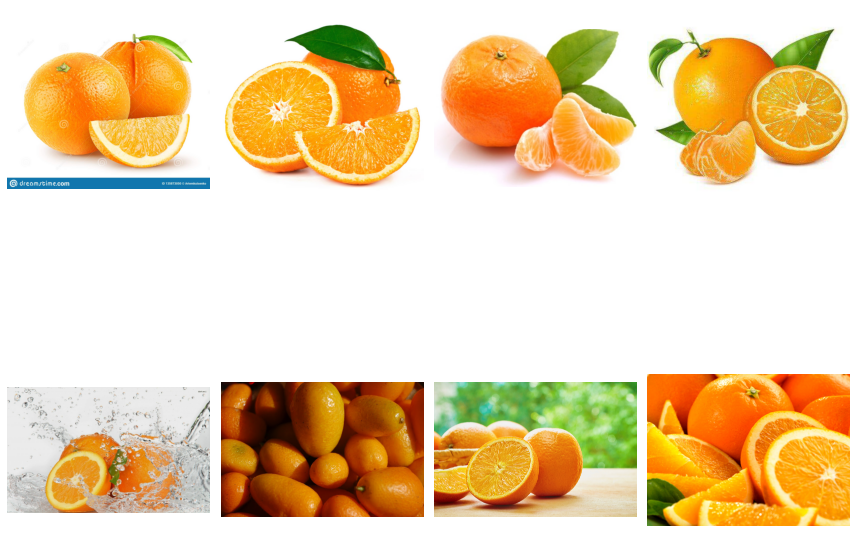

In [22]:
fig = plt.figure(figsize = (12,12))

for i, im in enumerate(rand_image):
    plt.subplot(2,4,i+1)
    im = cv2.imread(os.path.join("results/train/Orange",im))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.axis('off')

plt.tight_layout()
plt.show()

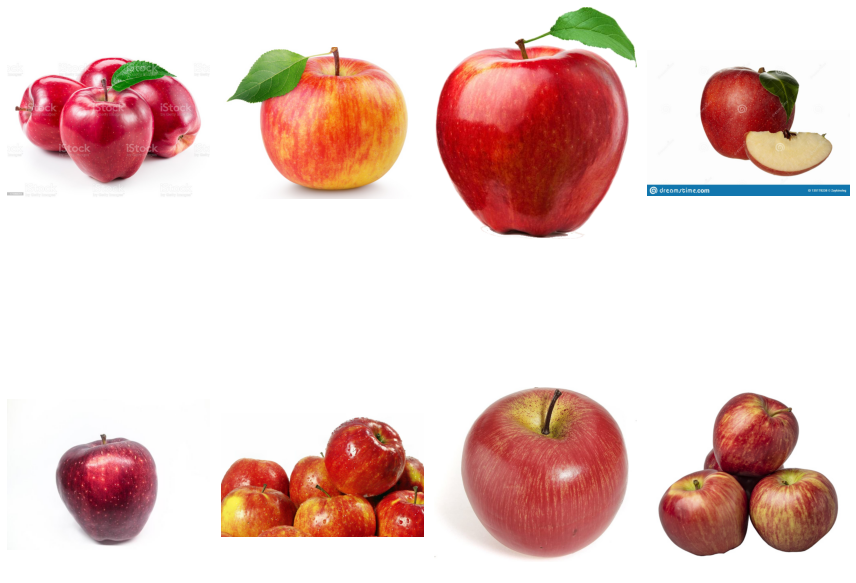

In [21]:
fig = plt.figure(figsize = (12,12))

for i, im in enumerate(rand_image_1):
    plt.subplot(2,4,i+1)
    im = cv2.imread(os.path.join("results/train/Apple",im))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Using MobileNet for Transfer Learning**

In [23]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(224,224,3))

9406464/9406464 [==============================] - 3s 0us/step


In [25]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [28]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    data_augmentation,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(8, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 sequential (Sequential)     (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                        

In [29]:
def scheduler(epoch):
    if epoch <= 3:
        return 0.001
    elif epoch > 3 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [33]:
EPOCHS = 20
hist = model.fit(X_train,y_train,epochs = EPOCHS, callbacks = [lr_callbacks],validation_data = (X_test,y_test))

Epoch 1/20
18/18 [==============================] - 23s 1s/step - loss: 0.8460 - accuracy: 0.7222 - val_loss: 0.4666 - val_accuracy: 0.8714 - lr: 0.0010
Epoch 2/20
18/18 [==============================] - 17s 949ms/step - loss: 0.1275 - accuracy: 0.9624 - val_loss: 0.3967 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 3/20
18/18 [==============================] - 17s 960ms/step - loss: 0.0366 - accuracy: 0.9910 - val_loss: 0.3236 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 4/20
18/18 [==============================] - 16s 874ms/step - loss: 0.0178 - accuracy: 0.9982 - val_loss: 0.2979 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 5/20
18/18 [==============================] - 19s 1s/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.2865 - val_accuracy: 0.9286 - lr: 1.0000e-04
Epoch 6/20
18/18 [==============================] - 16s 869ms/step - loss: 0.0162 - accuracy: 0.9964 - val_loss: 0.2783 - val_accuracy: 0.9286 - lr: 1.0000e-04
Epoch 7/20
18/18 [==============================] - 15s 866ms/

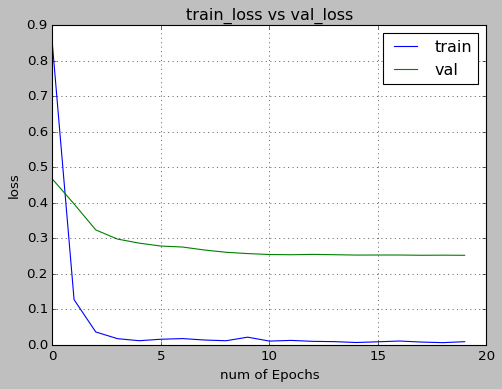

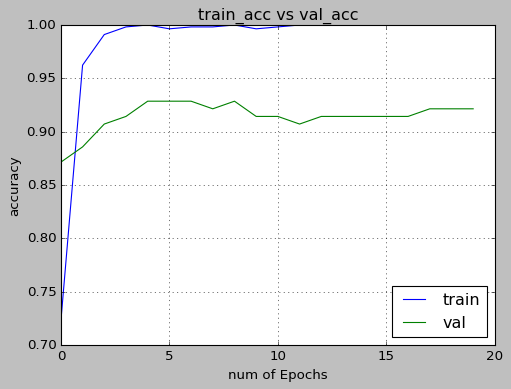

In [36]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [39]:
hist.history['val_loss']

[0.4665972590446472,
 0.39671263098716736,
 0.3236457109451294,
 0.2979463040828705,
 0.2864888310432434,
 0.27830493450164795,
 0.275537371635437,
 0.2672261595726013,
 0.26084890961647034,
 0.2571139633655548,
 0.25452056527137756,
 0.2538785934448242,
 0.254896342754364,
 0.25392746925354004,
 0.2529446482658386,
 0.2531001567840576,
 0.2530781924724579,
 0.2523590922355652,
 0.25264471769332886,
 0.25228849053382874]

In [50]:
def predict(img_name,model):
    img = image.load_img(img_name,target_size = (224,224))
    img = image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img = preprocess_input(img)
    prediction = model.predict(img.reshape(1,224,224,3))
    output = np.argmax(prediction)
    print(train_class[output])

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.astype('int32'))
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

In [51]:
predictions=[]

for img in test_images:
    img=img.reshape(1,224,224,3)
    predictions.append(model.predict(img))

1/1 [==============================] - 0s 30ms/step


In [52]:
pred_labels = model.predict(test_images)

3/3 [==============================] - 2s 601ms/step


In [53]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_images_label, pred_labels, target_names=test_class))

              precision    recall  f1-score   support

       Apple       1.00      0.92      0.96        13
      Banana       0.93      1.00      0.96        13
      Cherry       0.87      1.00      0.93        13
Dragon Fruit       1.00      0.93      0.96        14
       Mango       0.80      0.80      0.80        10
      Orange       1.00      1.00      1.00        13
      Papaya       0.75      0.86      0.80         7
   Pineapple       1.00      0.83      0.91        12

   micro avg       0.93      0.93      0.93        95
   macro avg       0.92      0.92      0.92        95
weighted avg       0.93      0.93      0.93        95
 samples avg       0.93      0.93      0.93        95



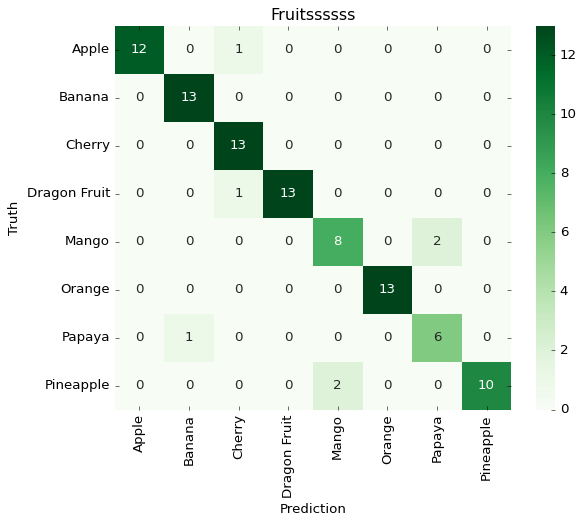

In [54]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_images_label, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= test_class,
                yticklabels=test_class)

plt.title('Fruitssssss')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

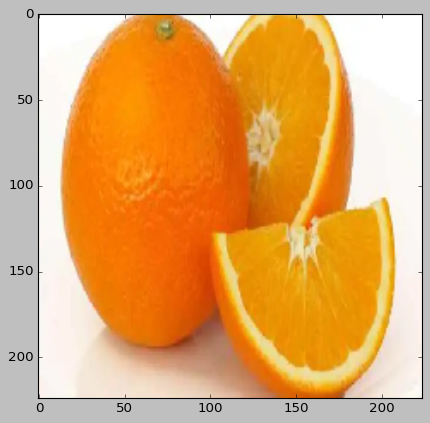

1/1 [==============================] - 0s 33ms/step
Orange


In [56]:
predict(("results/test/Orange/Image_53.jpg"),model)